In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3

# Demo de Modelos de Difusión
Este notebook demuestra la configuración, entrenamiento y carga de varios modelos de difusión (VE, VP, Sub-VP) sobre un subconjunto del dataset MNIST.

## 1. Importaciones y Configuración Inicial

In [ ]:
# Configuración para autoreload en notebooks (opcional)
%load_ext autoreload
%autoreload 2

# Bibliotecas estándar
import os
import sys
from functools import partial

# Ignorar warnings para mantener la salida limpia
import warnings
warnings.filterwarnings("ignore")

# Bibliotecas de terceros
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.optim import Adam
import tqdm

from torch.utils.data import (
    DataLoader,
    Dataset,
    Subset,
    TensorDataset # Necesario para FID
)

# --- Añadir rutas a módulos locales ---
# Asegúrate de que estas rutas sean correctas respecto a la ubicación del notebook
# Es preferible tener una estructura de paquete, pero esto funciona para scripts/notebooks.
try:
		paths_to_add = ["diffusion", "utils", "models", "metrics", "samplers", "diffusion_utilities"]
		for path_name in paths_to_add:
				if os.path.abspath(path_name) not in sys.path:
							sys.path.insert(0, os.path.abspath(path_name))

    # --- Importar módulos locales ---
		from sde import VESDE, VPSDE, SubVPSDE
		from schedules import LinearSchedule, CosineSchedule # NoiseSchedule no se usó en el código original
		from score_model import ScoreNet
		from samplers import euler_maruyama, predictor_corrector, probability_flow_ode, exponential_integrator
		# from metrics import fid, inception_score, bpd
		from diffusion_utilities import (
        plot_image_grid,
        plot_image_evolution,
        animation_images,
				plot_image_evolution_flow_ode,
    )
		from fid_MNIST import *
		from fid_calculator import *
		SAMPLER_FOR_FID = euler_maruyama.euler_maruyama_integrator
		SAMPLER_N_STEPS = 500
		print("Módulos locales importados correctamente.")
		from bpd import (check_data_preprocessing, calculate_bpd,
                         compute_nll_scipy) # Reemplaza con tus imports reales

		from inception_score import get_inception_score_for_generated_images

except ImportError as e:
    print(f"Error importando módulos locales: {e}")
    print("Asegúrate de que las rutas en sys.path sean correctas y los módulos existan.")
    # Decide si quieres detener la ejecución o continuar con funcionalidades limitadas
    raise

Módulos locales importados correctamente.


## 2. Configuración del Experimento
Modifica las variables en esta celda para seleccionar el modelo y ajustar los parámetros.

In [6]:
# --- Selección del Modelo ---
# Elige uno: 'VE', 'VP_Linear', 'VP_Cosine', 'SubVP_Linear', 'SubVP_Cosine'
MODEL_TYPE = 'VP_Linear'  # <--- CAMBIA ESTO PARA SELECCIONAR EL MODELO

# --- Configuración del Dataset ---
DATASET_ROOT = 'data'
TARGET_DIGIT = 3         # Dígito de MNIST para entrenar (0-9)

# --- Parámetros SDE/Schedule ---
SIGMA_MIN = 0.01         # Requerido por VESDE (ajustar si es necesario)
SIGMA_MAX = 50.0          # Requerido por VESDE (ajustar si es necesario)
SIGMA = 25.0						# Requerido por VESDE (ajustar si es necesario)
BETA_MIN = 0.1           # Para LinearSchedule
BETA_MAX = 20.0           # Para LinearSchedule
SCHEDULE_S = 0.008       # Para CosineSchedule
T_END = 1.0              # Tiempo final para schedules/SDEs

# --- Parámetros de Entrenamiento ---
BATCH_SIZE = 32
LEARNING_RATE = 1.0e-4
N_EPOCHS = 15            # Número de épocas de entrenamiento (poner 0 para solo cargar)
FORCE_TRAINING = False   # Poner True para entrenar incluso si existe un checkpoint

# --- Configuración de Checkpoints ---
CHECKPOINT_DIR = 'checkpoints_MNIST' # Directorio para guardar los modelos
os.makedirs(CHECKPOINT_DIR, exist_ok=True) # Crea el directorio si no existe
# Nombre de archivo dinámico basado en la configuración

CHECKPOINT_FILENAME = f"check_point_{MODEL_TYPE}.pth"
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, CHECKPOINT_FILENAME)

# --- Configuración del Hardware ---
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("GPU disponible. Usando CUDA.")
else:
    DEVICE = torch.device('cpu')
    print("GPU no encontrada. Usando CPU.")

# Número de threads para DataLoader (ajustar según sea necesario)
N_THREADS = torch.get_num_threads()
NUM_WORKERS = min(4, N_THREADS) # Limitar workers para evitar sobrecarga
print(f'Usando {NUM_WORKERS} workers para DataLoader.')


# --- Configuración de FID ---
N_FID_SAMPLES = 10     # Num imágenes para FID (reducir si hay problemas de memoria/tiempo)
FID_BATCH_SIZE = 64      # Batch size para la red Inception durante el cálculo FID
GEN_BATCH_SIZE_FID = 128 # Batch size para generar las imágenes (puede ser > FID_BATCH_SIZE)
FID_DIMS = 2048          # Dimensiones de las activaciones Inception (2048 es estándar)
BINARIZE_FID_IMAGES = True # Binarizar imágenes generadas y reales antes de FID? (Recomendado para MNIST)

SAMPLER_FOR_FID = euler_maruyama.euler_maruyama_integrator

GPU no encontrada. Usando CPU.
Usando 4 workers para DataLoader.


## 3. Carga y Preparación de Datos

In [7]:
print(f"Cargando dataset MNIST desde: {DATASET_ROOT}")
try:
    full_dataset = datasets.MNIST(
        root=DATASET_ROOT,
        train=True,
        download=True,
        transform=ToTensor()
    )
    print(f"Tipo de dataset completo: {type(full_dataset)}")

    # Crear subconjunto con el dígito seleccionado
    print(f"Filtrando dataset para el dígito: {TARGET_DIGIT}")
    indices_digit = torch.where(full_dataset.targets == TARGET_DIGIT)[0]
    if len(indices_digit) == 0:
         raise ValueError(f"No se encontraron imágenes para el dígito {TARGET_DIGIT} en el dataset.")
    train_dataset = Subset(full_dataset, indices_digit)
    print(f"Tipo de subconjunto: {type(train_dataset)}")
    print(f"Número de ejemplos de entrenamiento para el dígito {TARGET_DIGIT}: {len(train_dataset)}")

except Exception as e:
    print(f"Error cargando o procesando el dataset: {e}")
    raise

Cargando dataset MNIST desde: data
Tipo de dataset completo: <class 'torchvision.datasets.mnist.MNIST'>
Filtrando dataset para el dígito: 3
Tipo de subconjunto: <class 'torch.utils.data.dataset.Subset'>
Número de ejemplos de entrenamiento para el dígito 3: 6131


### Visualizar Datos de Entrenamiento

Visualizando algunos ejemplos de entrenamiento...


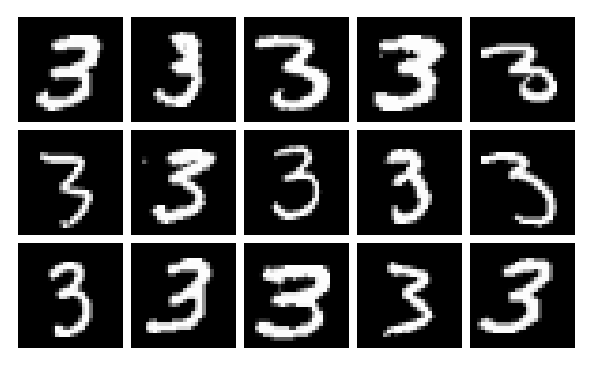

In [8]:
print("Visualizando algunos ejemplos de entrenamiento...")
n_rows_viz = 3
n_cols_viz = 5
num_images_to_show = min(n_rows_viz * n_cols_viz, len(train_dataset))

if num_images_to_show > 0:
    _ = plot_image_grid(
        images=[train_dataset[i][0] for i in range(num_images_to_show)],
        figsize=(n_cols_viz * 1.5, n_rows_viz * 1.5), # Ajustar tamaño dinámicamente
        n_rows=n_rows_viz,
        n_cols=n_cols_viz,
    )
    plt.show()
else:
    print("No hay imágenes para visualizar.")

## 4. Inicialización del Modelo y SDE

Se inicializa la Red de Score (ScoreNet) y la Ecuación Diferencial Estocástica (SDE) según la configuración seleccionada.

In [9]:

print(f"Inicializando tipo de modelo: {MODEL_TYPE}")

sde_instance = None
score_model = None

Inicializando tipo de modelo: VP_Linear


In [10]:
# --- Instanciar SDE según la configuración ---
try:
    if MODEL_TYPE == 'VE':
        sde_instance = VESDE(sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX, sigma=SIGMA)
        print(f"Inicializado VESDE (sigma_min={SIGMA_MIN}, sigma_max={SIGMA_MAX}, sigma={SIGMA})")
    elif MODEL_TYPE == 'VP_Linear':
        schedule = LinearSchedule(beta_min=BETA_MIN, beta_max=BETA_MAX, T=T_END)
        sde_instance = VPSDE(schedule=schedule)
        print(f"Inicializado VPSDE con Schedule Lineal (beta_min={BETA_MIN}, beta_max={BETA_MAX})")
    elif MODEL_TYPE == 'VP_Cosine':
        schedule = CosineSchedule(T=T_END, s=SCHEDULE_S)
        sde_instance = VPSDE(schedule=schedule)
        print(f"Inicializado VPSDE con Schedule Coseno (s={SCHEDULE_S})")
    elif MODEL_TYPE == 'SubVP_Linear':
        schedule = LinearSchedule(beta_min=BETA_MIN, beta_max=BETA_MAX, T=T_END)
        sde_instance = SubVPSDE(schedule=schedule)
        print(f"Inicializado SubVPSDE con Schedule Lineal (beta_min={BETA_MIN}, beta_max={BETA_MAX})")
    elif MODEL_TYPE == 'SubVP_Cosine':
        schedule = CosineSchedule(T=T_END, s=SCHEDULE_S)
        sde_instance = SubVPSDE(schedule=schedule)
        print(f"Inicializado SubVPSDE con Schedule Coseno (s={SCHEDULE_S})")
    else:
        raise ValueError(f"Tipo de modelo desconocido: {MODEL_TYPE}")

    # --- Instanciar el Modelo de Score ---
    score_model_base = ScoreNet(marginal_prob_std=partial(sde_instance.sigma_t))
    score_model = torch.nn.DataParallel(score_model_base) # Usar DataParallel para multi-GPU si está disponible
    score_model = score_model.to(DEVICE)
    print(f"Inicializado ScoreNet y movido a {DEVICE}.")

except Exception as e:
    print(f"Error durante la inicialización del modelo o SDE: {e}")
    raise

Inicializado VPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
Inicializado ScoreNet y movido a cpu.


## 5. Carga de Checkpoint o Entrenamiento

In [11]:
needs_training = False # Flag para saber si necesitamos entrenar

# Comprobar si existe el checkpoint y no se fuerza el entrenamiento
if os.path.exists(CHECKPOINT_PATH) and not FORCE_TRAINING:
    print(f"Intentando cargar checkpoint desde: {CHECKPOINT_PATH}")
    try:
        score_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))
        score_model.eval() # Poner el modelo en modo evaluación
        print("Checkpoint cargado con éxito.")
        needs_training = False
    except FileNotFoundError:
        print("Archivo de checkpoint no encontrado.")
        if N_EPOCHS > 0:
             print("Se procederá al entrenamiento.")
             needs_training = True
        else:
             print("N_EPOCHS es 0, no se entrenará.")
             # Lanzamos un error ya que no se puede continuar sin un modelo entrenado
             raise FileNotFoundError(f"Checkpoint requerido no encontrado en {CHECKPOINT_PATH} y N_EPOCHS=0.")

elif N_EPOCHS > 0:
    print(f"No se encontró checkpoint en {CHECKPOINT_PATH} o se forzó el entrenamiento.")
    print("Iniciando entrenamiento...")
    needs_training = True
else:
    print("No se encontró checkpoint y N_EPOCHS es 0. Se omite el entrenamiento.")
    raise FileNotFoundError(f"Checkpoint requerido no encontrado en {CHECKPOINT_PATH} y N_EPOCHS=0.")


# --- Bucle de Entrenamiento ---
if needs_training:
    print(f"Configuración de entrenamiento: Épocas={N_EPOCHS}, Batch Size={BATCH_SIZE}, LR={LEARNING_RATE}")

    # Crear DataLoader para el entrenamiento
    data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )

    # Configurar optimizador
    optimizer = Adam(score_model.parameters(), lr=LEARNING_RATE)

    # Poner modelo en modo entrenamiento
    score_model.train()

    # Bucle principal de entrenamiento con barra de progreso
    tqdm_epoch = tqdm.trange(N_EPOCHS)
    for epoch in tqdm_epoch:
        avg_loss = 0.0  # Inicializamos la pérdida promedio de la época.
        num_items = 0   # Inicializamos el contador de ejemplos procesados.

        # Barra de progreso para los batches dentro de la época
        batch_iterator = tqdm.tqdm(data_loader, desc=f"Época {epoch+1}/{N_EPOCHS}", leave=False)
        for x, _ in batch_iterator: # Las etiquetas 'y' no se usan en esta función de pérdida
            x = x.to(DEVICE) # Mover datos al dispositivo

            # Calcular la pérdida usando la función del SDE seleccionado
            loss = sde_instance.loss_function(score_model=score_model, x_0=x)

            # Backpropagation
            optimizer.zero_grad() # Limpiar gradientes anteriores
            loss.backward()       # Calcular gradientes

            optimizer.step()      # Actualizar pesos

            # Acumulamos la pérdida total ponderada por el tamaño del batch.
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]

            # Actualizar descripción de la barra de progreso del batch
            batch_iterator.set_postfix(loss=f"{loss.item():.4f}")

        # Calcular y mostrar pérdida promedio de la época
        epoch_avg_loss = avg_loss / num_items
        tqdm_epoch.set_description(f'Época {epoch+1}/{N_EPOCHS} | Average Loss: {epoch_avg_loss:.5f}')

        torch.save(score_model.state_dict(), CHECKPOINT_PATH)
        print(f"Checkpoint guardado en {CHECKPOINT_PATH}")

    print("Entrenamiento finalizado.")
    # Poner el modelo de nuevo en modo evaluación después de entrenar
    score_model.eval()

Intentando cargar checkpoint desde: checkpoints_MNIST\check_point_VP_Linear.pth
Checkpoint cargado con éxito.


## 6. Demostración del Modelo / Generación de Muestras

Esta sección utiliza el modelo cargado o entrenado para generar imágenes utilizando secuencialmente varios samplers disponibles (Euler-Maruyama, Probability Flow ODE, Exponential Integrator, Predictor-Corrector).

### 6.1 Generación con Euler Maruyama

In [12]:
n_images = 3

# 1) Cálculo de sigma^2(T) con la fórmula dada
if MODEL_TYPE == 'VE':
		# Para VESDE, usamos la fórmula sigma^2(T) = (sigma^(2T) - 1) / (2 * log(sigma))
		# Esta fórmula es válida para VESDE y se deriva de la ecuación diferencial estocástica.
    sigma_cuadrado_evaluado_en_T = ((sde_instance.sigma**(2.0 * T_END)) - 1.0) / (2.0 * np.log(sde_instance.sigma))
    # sigma_cuadrado_evaluado_en_T = sde_instance.sigma_t(T_END)**2
else:
		# Para VPSDE y SubVPSDE, usamos la función sigma_t para obtener sigma^2(T)
		sigma_cuadrado_evaluado_en_T = sde_instance.sigma_t(T_END)**2

# 2) Creación de un tensor de ruido con media 0 y varianza 1
#    El shape (n_images, 1, 28, 28) representa un lote de n_images de 1 canal 28x28
noise = torch.randn(n_images, 1, 28, 28, device=DEVICE)

# 3) Escalar el ruido para que tenga varianza sigma_cuadrado_evaluado_en_T
image_T = noise * np.sqrt(sigma_cuadrado_evaluado_en_T)

with torch.no_grad():
    times, synthetic_images_t = euler_maruyama.euler_maruyama_integrator(
        image_T,
        t_0 = T_END,
        t_end = 1.0e-3,
        n_steps = 500,
        drift_coefficient = partial(
          sde_instance.backward_drift_coefficient,
            score_model = score_model,
        ),
        diffusion_coefficient = sde_instance.diffusion_coefficient,
    )

print(type(synthetic_images_t))
print(synthetic_images_t.shape)

<class 'torch.Tensor'>
torch.Size([3, 1, 28, 28, 501])


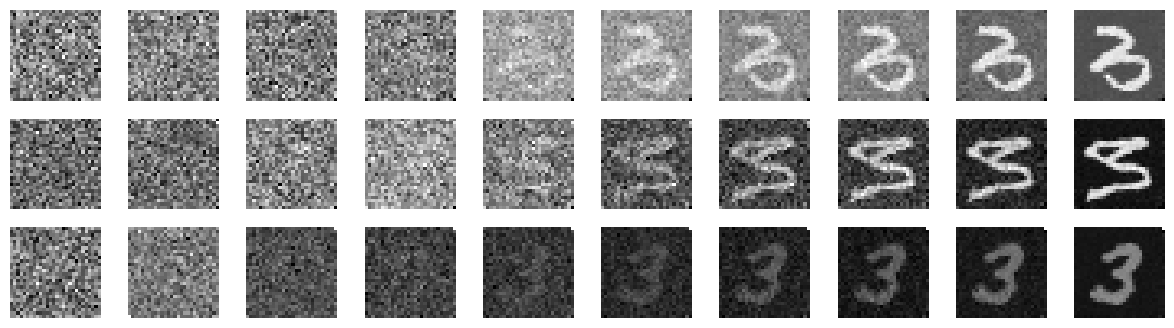

In [13]:
_ = plot_image_evolution(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 100, 200, 300, 400, 450, 470, 480, 490, 500],
    figsize=(15, 4),
)

### 6.2 Generación con Probability Flow ODE

Genera imágenes utilizando el integrador determinista basado en la ODE de Flujo de Probabilidad asociada a la SDE.


In [14]:
# --- Configuración específica para Probability Flow ODE ---
PF_ODE_N_IMAGES = 6             # Número de imágenes a generar con este sampler
PF_ODE_N_STEPS = 1200           # Número de pasos de integración para la ODE
PF_ODE_T_END_SAMPLING = 1e-5    # Tiempo final para la integración inversa (puede ser muy cercano a 0 para ODEs)
PF_ODE_N_IMAGES_PLOT = 3        # Cuántas de las imágenes generadas mostrar en la evolución
PF_ODE_N_INTERMEDIATE_STEPS = 6 # Cuántos pasos intermedios mostrar en la gráfica de evolución

In [15]:
# --- 1. Inicializar x(T) desde el prior ---
# 1) Cálculo de sigma^2(T) con la fórmula dada
if MODEL_TYPE == 'VE':
    # Para VESDE, usamos la fórmula sigma^2(T) = (sigma^(2T) - 1) / (2 * log(sigma))
    # Esta fórmula es válida para VESDE y se deriva de la ecuación diferencial estocástica.
    sigma_cuadrado_evaluado_en_T = ((sde_instance.sigma**(2.0 * T_END)) - 1.0) / (2.0 * np.log(sde_instance.sigma))
    # sigma_cuadrado_evaluado_en_T = sde_instance.sigma_t(T_END)**2
else:
    # Para VPSDE y SubVPSDE, usamos la función sigma_t para obtener sigma^2(T)
    sigma_cuadrado_evaluado_en_T = sde_instance.sigma_t(T_END)**2

# 2) Creación de un tensor de ruido con media 0 y varianza 1
#    El shape (N_IMAGES_TO_GENERATE, 1, 28, 28) representa un lote de n_images de 1 canal 28x28
noise = torch.randn(PF_ODE_N_IMAGES_PLOT, 1, 28, 28, device=DEVICE)

# 3) Escalar el ruido para que tenga varianza sigma_cuadrado_evaluado_en_T
image_T = noise * np.sqrt(sigma_cuadrado_evaluado_en_T)

print(f" Ruido inicial x(T) generado. Shape: {image_T.shape}")

## Creación de las imagenes en tiempo T tambien para Exponencial Integrator
image_T_exponential = image_T.clone()

 Ruido inicial x(T) generado. Shape: torch.Size([3, 1, 28, 28])


--- Ejecutando Probability Flow ODE Sampler ---
 Parámetros: N Imágenes=6, N Pasos=1200, t_end=1e-05
 Generación con PF ODE completada.
  Tipo de salida: <class 'torch.Tensor'>
  Shape de la trayectoria: torch.Size([3, 1, 28, 28, 1201])
  Shape imágenes finales: torch.Size([3, 1, 28, 28])
 Visualizando evolución (PF ODE)...


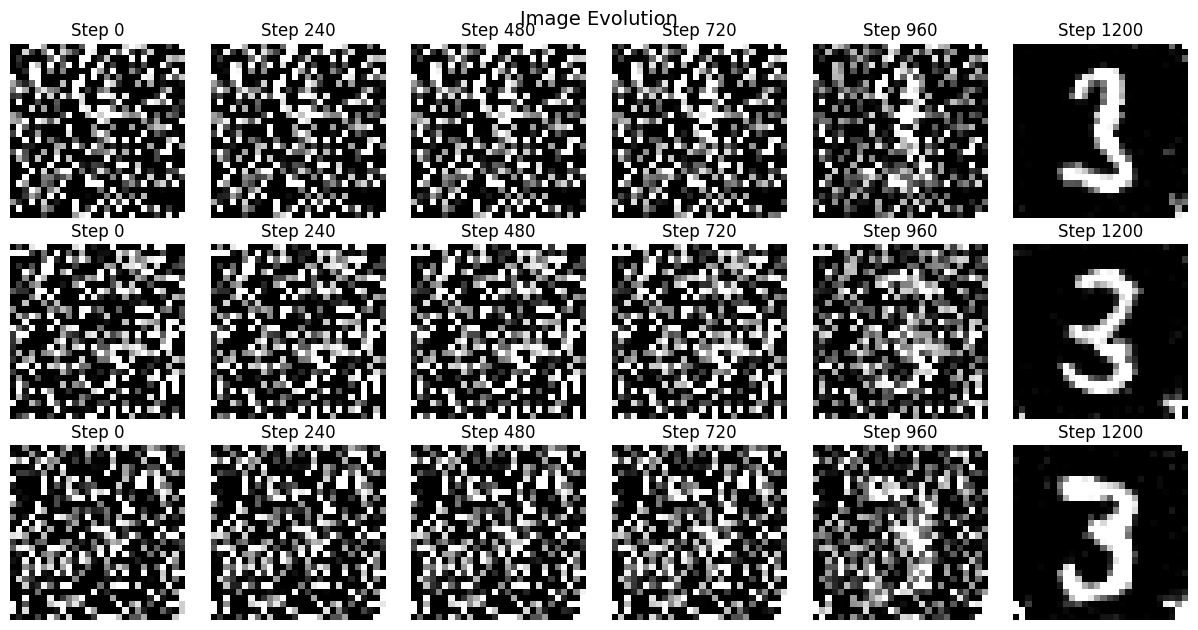

In [16]:
# probability_flow_ode_integrator, plot_image_evolution_flow_ode

print(f"--- Ejecutando Probability Flow ODE Sampler ---")
print(f" Parámetros: N Imágenes={PF_ODE_N_IMAGES}, N Pasos={PF_ODE_N_STEPS}, t_end={PF_ODE_T_END_SAMPLING}")

# --- 2. Ejecutar el integrador ODE ---
times_ode = None
synthetic_images_t_ode = None
with torch.no_grad():
    # Usar la función importada del sampler PF ODE
    times_ode, synthetic_images_t_ode = probability_flow_ode.probability_flow_ode_integrator(
        x_start = image_T,          # Ruido inicial
        sde = sde_instance,         # Instancia SDE global
        score_model = score_model,  # Modelo de score global
        t_start = T_END,            # Tiempo inicial global
        t_end = PF_ODE_T_END_SAMPLING, # Tiempo final específico para este sampler
        n_steps = PF_ODE_N_STEPS,   # Pasos específicos para este sampler
        device = DEVICE             # Dispositivo global
		)
if synthetic_images_t_ode is not None:
    print(f" Generación con PF ODE completada.")
    print(f"  Tipo de salida: {type(synthetic_images_t_ode)}")
    print(f"  Shape de la trayectoria: {synthetic_images_t_ode.shape}") # Esperado (N, C, H, W, Steps+1)
    # Extraer imágenes finales
    final_images_ode = synthetic_images_t_ode[..., -1].cpu()
    print(f"  Shape imágenes finales: {final_images_ode.shape}")
    # --- 3. Visualizar Evolución ---
    print(" Visualizando evolución (PF ODE)...")
    n_steps_in_trajectory = synthetic_images_t_ode.shape[-1] - 1
    if n_steps_in_trajectory > 0:
        # Seleccionar índices intermedios
        intermediate_indices = np.linspace(
            0, n_steps_in_trajectory,
            num=min(PF_ODE_N_INTERMEDIATE_STEPS, n_steps_in_trajectory + 1),
            dtype=int
				)
        # Usar la función de visualización para ODEs
        fig, axs = plot_image_evolution_flow_ode(
            images=synthetic_images_t_ode[:PF_ODE_N_IMAGES_PLOT].cpu(), # Mostrar evolución de N imágenes
            n_images=PF_ODE_N_IMAGES_PLOT,
            n_intermediate_steps=intermediate_indices.tolist(),
            figsize=(12, PF_ODE_N_IMAGES_PLOT * 2), # Ajustar tamaño
            cmap="gray", # Opcional
        )
        if fig: plt.show()
    else:
        print(" No hay suficientes pasos en la trayectoria para mostrar evolución.")
else:
    print(" La ejecución del sampler PF ODE no produjo resultados.")


### 6.3 Generación con Exponential Integrator

Genera imágenes utilizando un integrador ODE exponencial.


**Nota:** Este método generalmente asume una SDE de tipo VP o SubVP y no funciona correctamente con VE SDE. Se omitirá la ejecución si `MODEL_TYPE` es 'VE'.


In [17]:
# --- Configuración específica para Exponential Integrator ---
EXP_N_IMAGES = 6             # Número de imágenes a generar con este sampler
EXP_N_STEPS = 1000           # Número de pasos de integración (ajustar según sea necesario)
EXP_T_END_SAMPLING = 1e-5    # Tiempo final para la integración inversa
EXP_N_IMAGES_PLOT = 3        # Cuántas de las imágenes generadas mostrar en la evolución
EXP_N_INTERMEDIATE_STEPS = 6 # Cuántos pasos intermedios mostrar en la gráfica de evolución

--- Ejecutando Exponential Integrator Sampler ---
 Parámetros: N Imágenes=6, N Pasos=1000, t_end=1e-05
 Generación con Exponential Integrator completada.
  Tipo de salida: <class 'torch.Tensor'>
  Shape de la trayectoria: torch.Size([3, 1, 28, 28, 1001])
  Shape imágenes finales: torch.Size([3, 1, 28, 28])
 Visualizando evolución (Exponential Integrator)...


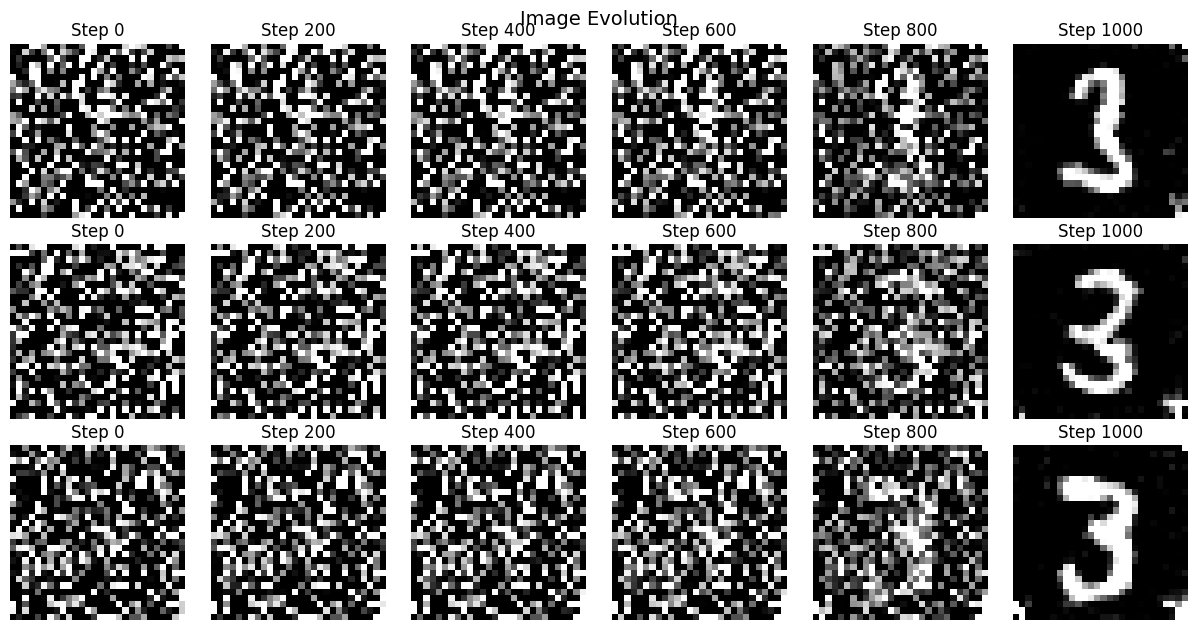

In [18]:
print(f"--- Ejecutando Exponential Integrator Sampler ---")
print(f" Parámetros: N Imágenes={EXP_N_IMAGES}, N Pasos={EXP_N_STEPS}, t_end={EXP_T_END_SAMPLING}")

if not MODEL_TYPE.startswith('VE'):
		# --- 2. Ejecutar el integrador Exponential Euler ODE ---
		times_exp = None
		synthetic_images_t_exp = None
		with torch.no_grad():
				# Usar la función importada del sampler Exponencial Integrator
				times_exp, synthetic_images_t_exp = exponential_integrator.exponential_euler_ode_sampler(
						x_start = image_T_exponential,    # Ruido inicial
						sde = sde_instance,         # Instancia SDE global (VP o SubVP)
						score_model = score_model,  # Modelo de score global
						t_start = T_END,            # Tiempo inicial global
						t_end = EXP_T_END_SAMPLING, # Tiempo final específico
						n_steps = EXP_N_STEPS,      # Pasos específicos
						device = DEVICE             # Dispositivo global
				)
		if synthetic_images_t_exp is not None:
				print(f" Generación con Exponential Integrator completada.")
				print(f"  Tipo de salida: {type(synthetic_images_t_exp)}")
				print(f"  Shape de la trayectoria: {synthetic_images_t_exp.shape}") # Esperado (N, C, H, W, Steps+1)
				# Extraer imágenes finales
				final_images_exp = synthetic_images_t_exp[..., -1].cpu()
				print(f"  Shape imágenes finales: {final_images_exp.shape}")
				# --- 3. Visualizar Evolución ---
				print(" Visualizando evolución (Exponential Integrator)...")
				n_steps_in_trajectory = synthetic_images_t_exp.shape[-1] - 1
				if n_steps_in_trajectory > 0:
						intermediate_indices = np.linspace(
								0, n_steps_in_trajectory,
								num=min(EXP_N_INTERMEDIATE_STEPS, n_steps_in_trajectory + 1),
								dtype=int
						)
						fig, axs = plot_image_evolution_flow_ode(
							images=synthetic_images_t_exp[:EXP_N_IMAGES_PLOT].cpu(),
							n_images=EXP_N_IMAGES_PLOT,
							n_intermediate_steps=intermediate_indices.tolist(),
							figsize=(12, EXP_N_IMAGES_PLOT * 2),
							cmap="gray", # Opcional
						)
						if fig:
								plt.show()
				else:
						print(" No hay suficientes pasos en la trayectoria para mostrar evolución.")

else:
		print('El sampler Exponential Integrator no es aplicable para el modelo VE.')

### 6.4 Generación con Predictor-Corrector

Genera imágenes utilizando un esquema Predictor-Corrector. Este método suele ser computacionalmente más intensivo pero puede producir muestras de alta calidad.

In [19]:
# --- Configuración específica para Predictor-Corrector ---
PC_N_IMAGES = 6             # Número de imágenes a generar
# PC_N_STEPS = 1000            # Número de pasos del predictor (N)
PC_N_STEPS = 2000            # Número de pasos del predictor (N)
# PC_N_CORRECTOR_STEPS = 6    # Número de pasos del corrector (M) por cada paso del predictor
PC_N_CORRECTOR_STEPS = 2   # Número de pasos del corrector (M) por cada paso del predictor
# PC_SNR = 0.27               # Relación señal-ruido para el paso del corrector
PC_SNR = 0.15               # Relación señal-ruido para el paso del corrector
PC_T_END_SAMPLING = 1e-4    # Tiempo final para el muestreo (puede ser diferente a otros samplers)
PC_N_IMAGES_PLOT = 3        # Cuántas de las imágenes generadas mostrar en la evolución
PC_N_INTERMEDIATE_STEPS = 6 # Cuántos pasos intermedios mostrar en la gráfica de evolución

--- Ejecutando Predictor-Corrector Sampler ---
 Parámetros: N Imágenes=6, N Pred=2000, M Corr=2, SNR=0.15, t_end=0.0001
 Shape para generar: (6, 1, 28, 28)
 [Nota] El sampler Predictor-Corrector (basado en .sample(shape=...)) generalmente usa su propio ruido interno,
        por lo que no parte del mismo ruido inicial que los samplers anteriores.


100%|██████████| 2000/2000 [02:04<00:00, 16.01it/s]


 Generación con Predictor-Corrector completada.
  Tipo de salida: <class 'torch.Tensor'>
  Shape de la trayectoria: torch.Size([6, 1, 28, 28, 2001])
  Shape imágenes finales: torch.Size([6, 1, 28, 28])
 Visualizando evolución (Predictor-Corrector)...


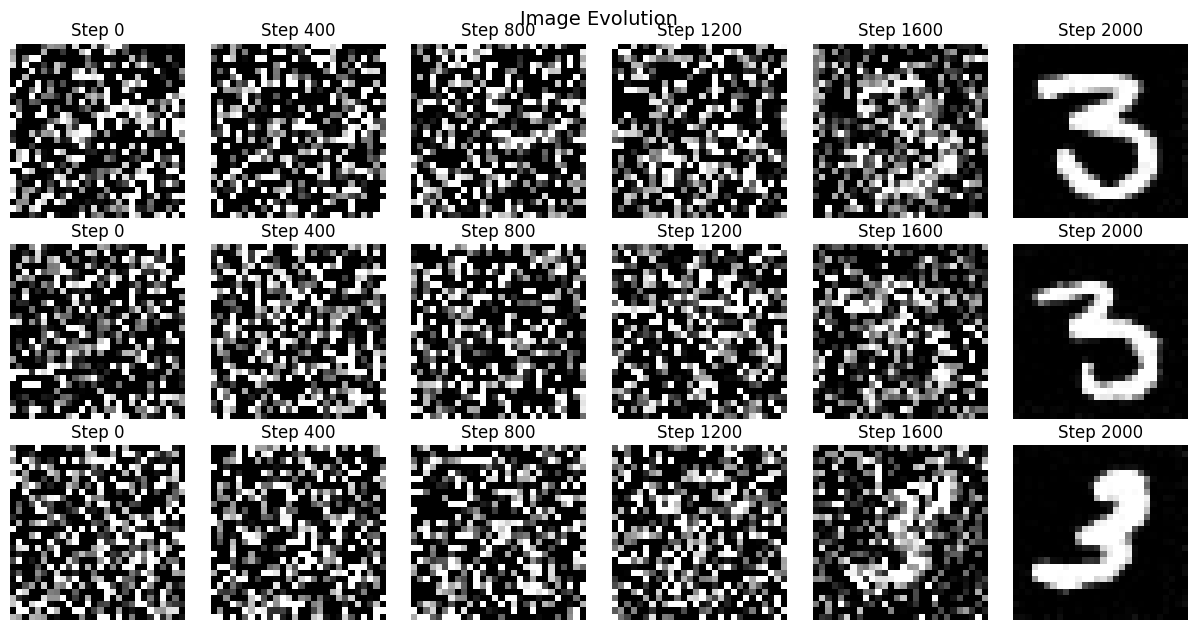

In [20]:
print(f"--- Ejecutando Predictor-Corrector Sampler ---")
print(f" Parámetros: N Imágenes={PC_N_IMAGES}, N Pred={PC_N_STEPS}, M Corr={PC_N_CORRECTOR_STEPS}, SNR={PC_SNR}, t_end={PC_T_END_SAMPLING}")

# --- 1. Definir Shape y Nota sobre Ruido Inicial ---
image_shape = (PC_N_IMAGES, 1, 28, 28) # MNIST

print(f" Shape para generar: {image_shape}")
print(" [Nota] El sampler Predictor-Corrector (basado en .sample(shape=...)) generalmente usa su propio ruido interno,")
print("        por lo que no parte del mismo ruido inicial que los samplers anteriores.")

# --- 2. Instanciar y Ejecutar el Sampler Predictor-Corrector ---
times_pc = None
trajectory_pc = None
final_images_pc = None

pc_sampler = predictor_corrector.PredictorCorrectorSampler(
    sde=sde_instance,                 # Instancia SDE global
    score_model=score_model,          # Modelo de score global
    num_steps=PC_N_STEPS,             # N pasos predictor
    num_corrector_steps=PC_N_CORRECTOR_STEPS, # M pasos corrector
    snr=PC_SNR,                       # SNR para corrector
    t_end=PC_T_END_SAMPLING,          # Tiempo final específico
    device=DEVICE                     # Dispositivo global
)
# Ejecutar el método .sample()
with torch.no_grad():
    # times_pc, trajectory_pc = pc_sampler.sample(shape=image_shape, model_type=MODEL_TYPE)
    times_pc, trajectory_pc = pc_sampler.sample(shape=image_shape)
if trajectory_pc is not None:
    print(f" Generación con Predictor-Corrector completada.")
    print(f"  Tipo de salida: {type(trajectory_pc)}")
    print(f"  Shape de la trayectoria: {trajectory_pc.shape}") # Esperado (N, C, H, W, Steps+1)
    final_images_pc = trajectory_pc[..., -1].cpu() # Extraer imágenes finales
    print(f"  Shape imágenes finales: {final_images_pc.shape}")
else:
    print(" La ejecución del sampler Predictor-Corrector no produjo una trayectoria.")

# --- 3. Visualizar Evolución ---
if trajectory_pc is not None and trajectory_pc.ndim == 5:
    print(" Visualizando evolución (Predictor-Corrector)...")
    # Usa pc_sampler.num_steps que es N (el número de pasos del predictor guardados en la trayectoria)
    n_steps_in_trajectory = trajectory_pc.shape[-1] - 1 # Debería ser pc_sampler.num_steps
    if n_steps_in_trajectory > 0:
        intermediate_indices = np.linspace(
            0, n_steps_in_trajectory,
            num=min(PC_N_INTERMEDIATE_STEPS, n_steps_in_trajectory + 1),
            dtype=int
        )
        fig, axs = plot_image_evolution_flow_ode(
						images=trajectory_pc[:PC_N_IMAGES_PLOT].cpu(),
						n_images=PC_N_IMAGES_PLOT,
						n_intermediate_steps=intermediate_indices.tolist(),
						figsize=(12, PC_N_IMAGES_PLOT * 2)
				)
        if fig: plt.show()
    else:
        print(" No hay suficientes pasos en la trayectoria para mostrar evolución.")

## 7. Métricas

### 7.1 Métrica BPD (Bits Per Dimension)

Esta sección calcula la métrica BPD, que mide la verosimilitud logarítmica negativa (Negative Log-Likelihood - NLL) asignada por el modelo a los datos reales (del conjunto de test), normalizada por la dimensionalidad de los datos. Valores más bajos indican un mejor ajuste del modelo a los datos.


In [21]:
# --- Configuración específica para BPD/NLL ---
EVAL_BATCH_SIZE = 128         # Tamaño de batch para evaluación NLL (ajustar según memoria)
NLL_T_START = 1e-5           # Tiempo inicial para la integración ODE de NLL
# NLL_T_END se tomará de la variable global T_END
NLL_RTOL = 1e-4              # Tolerancia relativa para el solver ODE
NLL_ATOL = 1e-4              # Tolerancia absoluta para el solver ODE
NLL_METHOD = 'RK45'          # Método del solver ODE (ej. 'RK45', 'DOP853')
NLL_USE_SUBSET = True        # Calcular BPD solo sobre el dígito TARGET_DIGIT del test set? (False para usar todo el test set)

In [22]:

print(f"--- Iniciando Cálculo de NLL / BPD ---")
print(f" Evaluando sobre: {'Subset del dígito ' + str(TARGET_DIGIT) if NLL_USE_SUBSET else 'MNIST Test Set completo'}")
print(f" Parámetros ODE NLL: t_start={NLL_T_START}, t_end={T_END}, rtol={NLL_RTOL}, atol={NLL_ATOL}, method='{NLL_METHOD}'")

# --- 1. Cargar Datos de Evaluación (MNIST Test Set) ---
print(" Cargando MNIST Test Set...")
mnist_test_set = datasets.MNIST(
    root='data',
    train=False, # Usar conjunto de test
    download=True,
    transform=ToTensor() # Escala a [0, 1]
)
print(f" Tamaño completo MNIST Test Set: {len(mnist_test_set)}")
# --- 2. Crear Dataset de Evaluación (Completo o Subset) ---

# --- Crear Subset (opcional, puedes usar el dataset completo) ---
digit_to_use = TARGET_DIGIT
try:
    # MNIST targets son tensores
    indices_digit = torch.where(mnist_test_set.targets == digit_to_use)[0]
    if len(indices_digit) == 0:
        print(f"Warning: No images found for digit {digit_to_use} in the dataset.")
        subset_dataset = mnist_test_set # Usar completo si no se encuentra el dígito
    else:
        subset_dataset = Subset(mnist_test_set, indices_digit)
        print(f"Created subset for digit {digit_to_use} with {len(subset_dataset)} images.")
except AttributeError:
     print("Warning: Could not access .targets on the dataset. Using full dataset.")
     subset_dataset = mnist_test_set


# Usa el subset o el dataset completo
eval_dataset = subset_dataset # O full_mnist_dataset
# --- 3. Crear DataLoader de Evaluación ---
eval_loader = DataLoader(
    eval_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False # No barajar para evaluación determinista
)
print(f" DataLoader de evaluación creado con {len(eval_loader)} batches.")
# --- 4. Calcular Dimensiones (opcional, informativo) ---
# Asume MNIST 1x28x28
img_channels = 1
img_height = 28
img_width = 28
dimensions = img_channels * img_height * img_width
print(f" Dimensiones de la imagen: {dimensions} (C={img_channels}, H={img_height}, W={img_width})")
# --- 5. Calcular NLL promedio usando la función importada ---
print(f"\n Calculando NLL (¡esto puede tardar mucho!)...")
avg_nll = compute_nll_scipy(
    data_loader=eval_loader,      # DataLoader con los datos de test
    sde=sde_instance,             # Instancia SDE global
    score_model=score_model,      # Modelo de score global
    device=DEVICE,                # Dispositivo global
    t_start=NLL_T_START,          # Tiempo inicial para ODE NLL
    t_end=T_END,                  # Tiempo final (debe coincidir con T de la SDE)
    rtol=NLL_RTOL,                # Tolerancia relativa solver
    atol=NLL_ATOL,                # Tolerancia absoluta solver
    method=NLL_METHOD,            # Método solver
    do_dequantize=True            # ¡IMPORTANTE para MNIST!
)
# --- 6. Calcular y Mostrar BPD ---
if avg_nll is not None:
    print(f"\n Cálculo de NLL finalizado.")
    print(f"  NLL promedio (base e): {avg_nll:.4f}")
    # Calcular BPD usando la función importada
    bpd_value = calculate_bpd(torch.tensor(avg_nll), dimensions)
    print(f" >>> Bits Per Dimension (BPD): {bpd_value.item():.4f}")
    print(f"     (Calculado para {MODEL_TYPE} sobre {'Subset Dig' + str(TARGET_DIGIT) if NLL_USE_SUBSET else 'Test Set Completo'})")
else:
    print("\n [Error] No se pudo calcular la NLL.")

--- Iniciando Cálculo de NLL / BPD ---
 Evaluando sobre: Subset del dígito 3
 Parámetros ODE NLL: t_start=1e-05, t_end=1.0, rtol=0.0001, atol=0.0001, method='RK45'
 Cargando MNIST Test Set...
 Tamaño completo MNIST Test Set: 10000
Created subset for digit 3 with 1010 images.
 DataLoader de evaluación creado con 8 batches.
 Dimensiones de la imagen: 784 (C=1, H=28, W=28)

 Calculando NLL (¡esto puede tardar mucho!)...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/8 [00:00<?, ?it/s]


--- Processing batch 1/8 ---
Data dimensions detected: 784
Initial batch shape: torch.Size([128, 1, 28, 28])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.51e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-956.55, delta_log_p=-3205.69, log_p_0=-4162.24, NLL=4162.24

--- Processing batch 2/8 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-900.79, delta_log_p=-3241.75, log_p_0=-4142.53, NLL=4142.53

--- Processing batch 3/8 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-911.08, delta_log_p=-3225.65, log_p_0=-4136.73, NLL=4136.73

--- Processing batch 4/8 ---
Solving ODE for

### 7.2 Métrica FID (Fréchet Inception Distance)

Esta sección calcula el FID comparando imágenes generadas por el modelo con imágenes reales del dataset. Un FID más bajo indica mayor similitud entre las distribuciones de imágenes reales y generadas.

In [23]:
# --- 1. Generar Imágenes Sintéticas ---
print(f"Generando {N_FID_SAMPLES} imágenes sintéticas con {MODEL_TYPE} para FID...")
# Nota: Asume que generate_samples_for_fid maneja el bucle de batches internamente
generated_images_fid = generate_samples_for_fid(
	score_model_sde=score_model,       # Modelo cargado/entrenado
	sde=sde_instance,                  # SDE instanciada
	sampler=SAMPLER_FOR_FID,           # Sampler seleccionado
	n_samples=N_FID_SAMPLES,
	batch_size=GEN_BATCH_SIZE_FID,
	t0= 1.0,# Tiempo inicial SDE (forward, ej: 1.0)
	t1=1e-3,                           # Tiempo final SDE (sampling, cerca de 0)
	n_steps=SAMPLER_N_STEPS,           # Pasos del solver
	device=DEVICE,
  model_type=MODEL_TYPE,         # Tipo de modelo
)
print(f"Imágenes generadas. Tensor shape: {generated_images_fid.shape}")

# --- Solución: Escalado Min-Max Global ---
# Escala todo el tensor al rango [0, 1] usando su propio min y max.

# 1. Comprobar si el tensor tiene rango cero (todos los elementos iguales)
min_val = torch.min(generated_images_fid)
max_val = torch.max(generated_images_fid)
data_range = max_val - min_val

# 2. Aplicar escalado Min-Max
if data_range > 1e-8: # Evitar división por cero si el rango es (casi) cero
    generated_images_fid = (generated_images_fid - min_val) / data_range
else:
    # Si todos los valores son iguales, podemos mapearlos a 0, 0.5 o 1.
    # Mapear a 0.5 es una opción común si el valor no es ya 0 o 1.
    # O simplemente dejarlo como está si ya está en [0,1], o poner a 0.
    print("Advertencia: El rango del tensor es casi cero. Escalando a 0.5.")
    generated_images_fid = torch.ones_like(generated_images_fid) * 0.5 # O poner a 0

# 3. (Opcional pero seguro) Aplicar clamp final para asegurar [0, 1] exacto
#    debido a posibles imprecisiones de punto flotante.
generated_images_fid = torch.clamp(generated_images_fid, 0.0, 1.0)

Generando 10 imágenes sintéticas con VP_Linear para FID...
Generando 10 muestras en 1 batches...


100%|██████████| 1/1 [00:08<00:00,  8.49s/it]

Rango de valores ANTES de preprocesar (FID): min=-0.4823, max=2.3046, mean=0.1890
Generadas 10 imágenes.
Imágenes generadas. Tensor shape: torch.Size([10, 1, 28, 28])


In [24]:
# --- 3. Preparar Imágenes Reales ---
print(f"Preparando hasta {N_FID_SAMPLES} imágenes reales del dígito {TARGET_DIGIT}...")
real_images_list_fid = []
# Usar train_dataset (Subset) que ya está filtrado por TARGET_DIGIT
num_real_available = len(train_dataset)
num_real_to_take = min(N_FID_SAMPLES, num_real_available)

if num_real_to_take < N_FID_SAMPLES:
	warnings.warn(f"Solo hay {num_real_to_take} imágenes reales disponibles para el dígito {TARGET_DIGIT} (se solicitaron {N_FID_SAMPLES}). Se usarán {num_real_to_take}.")

# Obtener las imágenes reales directamente del Subset
print(f" Tomando {num_real_to_take} imágenes reales...")
for i in range(num_real_to_take):
	real_img, _ = train_dataset[i] # Subset devuelve (imagen, label)
	real_images_list_fid.append(real_img)

if not real_images_list_fid:
	raise ValueError(f"No se pudieron obtener imágenes reales para el dígito {TARGET_DIGIT}.")

real_images_tensor_fid = torch.stack(real_images_list_fid).to(DEVICE) # Apilar y mover a DEVICE
print(f"Imágenes reales preparadas. Tensor shape: {real_images_tensor_fid.shape}")


Preparando hasta 10 imágenes reales del dígito 3...
 Tomando 10 imágenes reales...
Imágenes reales preparadas. Tensor shape: torch.Size([10, 1, 28, 28])


In [25]:
# --- 4. Crear DataLoaders para FID ---
print("Creando DataLoaders para FID...")
# Asegurarse que ambos tensores están en el mismo dispositivo
if generated_images_fid.shape[0] != num_real_to_take:
	warnings.warn(f"El número de imágenes generadas ({generated_images_fid.shape[0]}) y reales ({num_real_to_take}) difiere. FID se calculará usando {min(generated_images_fid.shape[0], num_real_to_take)} de cada una.")
	# Opcional: Truncar el más largo si la función calculate_fid lo requiere
	# min_count = min(generated_images_fid.shape[0], num_real_to_take)
	# generated_images_fid = generated_images_fid[:min_count]
	# real_images_tensor_fid = real_images_tensor_fid[:min_count]

# Ahora sí:
real_fid_dataset = TensorDataset(real_images_tensor_fid)
gen_fid_dataset  = TensorDataset(generated_images_fid)


real_fid_loader = DataLoader(real_fid_dataset, batch_size=FID_BATCH_SIZE, shuffle=False)
gen_fid_loader = DataLoader(gen_fid_dataset, batch_size=FID_BATCH_SIZE, shuffle=False)


Creando DataLoaders para FID...


In [26]:

# --- 5. Calcular FID ---
num_samples_for_fid_calc = min(len(real_fid_dataset), len(gen_fid_dataset))
print(f"\nCalculando FID con {num_samples_for_fid_calc} imágenes reales y {num_samples_for_fid_calc} generadas...")

# Llamada a la función externa que calcula FID
fid_score = calculate_fid(
	real_fid_loader,          # DataLoader de imágenes reales
	gen_fid_loader,           # DataLoader de imágenes generadas
	batch_size=FID_BATCH_SIZE,# Batch size para el modelo Inception
	device=DEVICE,
	dims=FID_DIMS,
	num_samples=num_samples_for_fid_calc # Número de muestras a usar
)
print(f"\n>>> FID Score ({MODEL_TYPE}, Dígito {TARGET_DIGIT}): {fid_score:.4f}")



Calculando FID con 10 imágenes reales y 10 generadas...
Cargando modelo InceptionV3 para FID...
Calculando estadísticas para imágenes reales...
Calculando estadísticas sobre 10 muestras (limitado).
Calculando activaciones...


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Calculando media y covarianza para 10 activaciones...
Estadísticas calculadas.
Calculando estadísticas para imágenes generadas...
Calculando estadísticas sobre 10 muestras (limitado).
Calculando activaciones...


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Calculando media y covarianza para 10 activaciones...
Estadísticas calculadas.
Calculando FID...
FID calculado: 232.1807925369651

>>> FID Score (VP_Linear, Dígito 3): 232.1808



--- Visualizando Algunas Imágenes Generadas (Usadas para FID) ---


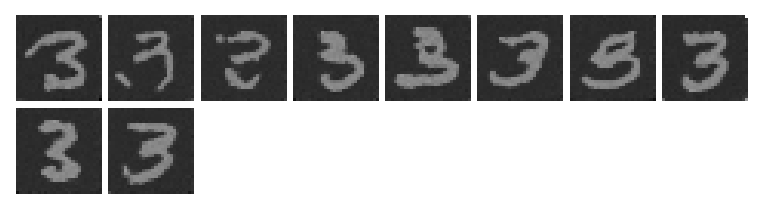

In [27]:
# --- 6. Visualizar Muestras Generadas (Opcional) ---
# Visualiza las imágenes *después* del preprocesamiento para FID
if 'generated_images_fid' in locals() and generated_images_fid.numel() > 0:
	print("\n--- Visualizando Algunas Imágenes Generadas (Usadas para FID) ---")
	n_rows_vis = 4
	n_cols_vis = 8
	num_to_plot = min(len(generated_images_fid), n_rows_vis * n_cols_vis)
	if num_to_plot > 0:
		plot_image_grid(
			images=generated_images_fid[:num_to_plot].cpu(), # Mover a CPU para plot
			n_rows=n_rows_vis,
			n_cols=n_cols_vis,
			figsize=(n_cols_vis * 1.2, n_rows_vis * 1.2), # Ajustar tamaño
		)
		plt.show()
	else:
		print("No hay imágenes generadas para mostrar.")
else:
	print("No se generaron imágenes para visualizar.")

### 7.3 Métrica Inception Score (IS)

Esta sección calcula el Inception Score, una métrica para evaluar la calidad y diversidad de las imágenes generadas. Utiliza un modelo Inception pre-entrenado en ImageNet.


**Advertencias:**
* **Número de Muestras:** IS requiere un número elevado de imágenes generadas (ej. 10k-50k) para ser fiable. Un número bajo (~1k) solo sirve para pruebas rápidas y dará resultados poco representativos.
* **Memoria:** Generar y procesar miles de imágenes puede consumir mucha memoria (GPU/RAM). Ajusta `IS_N_SAMPLES` y `IS_BATCH_SIZE`.
* **Rango de Imágenes:** Asegúrate de que las imágenes generadas estén en un rango adecuado (ej. [0, 1] o [-1, 1]) o que la función `get_inception_score_for_generated_images` maneje la normalización.



In [28]:
# --- Configuración específica para Inception Score ---
IS_N_SAMPLES = 1000           # !!! Aumentar a >=10000 para resultados fiables !!!
IS_SAMPLER_FUNC = euler_maruyama.euler_maruyama_integrator # Sampler a usar para generar imágenes para IS
IS_SAMPLER_N_STEPS = 500     # Pasos del sampler para generación IS
IS_SAMPLER_T_END = 1.0e-3      # Tiempo final del sampler para generación IS
IS_DEVICE = DEVICE           # Dispositivo para calcular IS ('cuda' o 'cpu'). CPU puede ser más estable si hay poca VRAM.
IS_BATCH_SIZE = 64           # Tamaño de batch para el modelo Inception durante el cálculo de IS
IS_N_SPLITS = 10             # Número de splits para calcular media y std (estándar=10)
image_shape = (1, 28, 28) # Para MNIST

In [29]:
sampler_func_for_is = IS_SAMPLER_FUNC

if IS_N_SAMPLES < 5000: # Advertencia si el número de muestras es bajo
     print(f"[Advertencia] Calculando IS con solo {IS_N_SAMPLES} muestras. El resultado puede no ser fiable. Se recomiendan >= 10000.")
if IS_N_SAMPLES % IS_N_SPLITS != 0:
     print(f"[Advertencia] IS_N_SAMPLES ({IS_N_SAMPLES}) no es divisible por IS_N_SPLITS ({IS_N_SPLITS}). La última división tendrá menos muestras.")
print(f"--- Iniciando Cálculo de Inception Score ---")
# --- 1. Generación Dedicada de Imágenes para IS ---

# ADVERTENCIA: Generar todas las imágenes en un solo batch puede causar OOM si IS_N_SAMPLES es grande.
# Considera implementar un bucle con batches más pequeños si encuentras problemas de memoria.
final_generated_images_for_is = None
try:
    # --- 1.1 Ruido Inicial x(T) ---
    t_end_tensor = torch.tensor(T_END, device=DEVICE)
    sigma_T = sde_instance.sigma_t(t_end_tensor)
    initial_noise_is = torch.randn(IS_N_SAMPLES, *image_shape, device=DEVICE) * sigma_T
    print(f"  Shape ruido inicial para IS: {initial_noise_is.shape}")
    # --- 1.2 Ejecutar Sampler ---
    print("Generating images for IS...")
    with torch.no_grad():
        # Usar el sampler definido en la configuración
        times_is, trajectory_is = sampler_func_for_is(
            initial_noise_is, # El sampler debe aceptar el tensor inicial
            t_0=T_END,
            t_end=IS_SAMPLER_T_END,
            n_steps=IS_SAMPLER_N_STEPS,
            drift_coefficient=partial(
                sde_instance.backward_drift_coefficient, # Funciona para EM
                score_model=score_model,
            ),
            diffusion_coefficient=sde_instance.diffusion_coefficient,
      	)

    final_generated_images_for_is = trajectory_is[..., -1] # Extraer imágenes finales
    print(f"  Imágenes para IS generadas. Shape final: {final_generated_images_for_is.shape}")

except RuntimeError as e: # Capturar errores comunes como OOM
     print(f"\n [ERROR] Ocurrió un error durante la generación de imágenes para IS (posible OOM): {e}")
     print(f"   Intenta reducir IS_N_SAMPLES ({IS_N_SAMPLES}) o implementa generación por batches.")
     final_generated_images_for_is = None # Asegurar que no se intente calcular IS
except Exception as e:
     print(f"\n [Error] Ocurrió un error inesperado durante la generación de imágenes para IS: {e}")
     import traceback
     traceback.print_exc()
     final_generated_images_for_is = None

# --- 2. Calcular Inception Score ---
if final_generated_images_for_is is not None:
    print(f"\n Calculando Inception Score en dispositivo: {IS_DEVICE}...")
    # Mover imágenes al dispositivo de cálculo de IS
    is_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    images_for_is_calc = final_generated_images_for_is.to(is_device)
    # Llamar a la función que calcula IS
    mean_is, std_is = get_inception_score_for_generated_images(
        generated_images=images_for_is_calc,
        batch_size=IS_BATCH_SIZE,
        n_splits=IS_N_SPLITS,
        device=IS_DEVICE
		)
    print(f"\n >>> Inception Score (IS) Calculado:")
    print(f"      Media: {mean_is:.4f}")
    print(f"      Std Dev: {std_is:.4f}")
    print(f"      (Calculado con {IS_N_SAMPLES} imágenes, {IS_N_SPLITS} splits, para {MODEL_TYPE})")

[Advertencia] Calculando IS con solo 1000 muestras. El resultado puede no ser fiable. Se recomiendan >= 10000.
--- Iniciando Cálculo de Inception Score ---
  Shape ruido inicial para IS: torch.Size([1000, 1, 28, 28])
Generating images for IS...
  Imágenes para IS generadas. Shape final: torch.Size([1000, 1, 28, 28])

 Calculando Inception Score en dispositivo: cpu...
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating Inception Score using 1000 images and 10 splits...

 >>> Inception Score (IS) Calculado:
      Media: 1.4792
      Std Dev: 0.0573
      (Calculado con 1000 imágenes, 10 splits, para VP_Linear)
